In [3]:

import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import tensorflow_hub as hub
import os
import tensorflow as tf

from tensorflow.keras import layer

In [4]:
# Define constants and load the data
BATCH_SIZE = 64
IMAGE_SIZE = (224, 224)
folder = '../input/utkface-new/UTKFace'

df = pd.DataFrame(os.listdir(folder), columns=['f_name'])
df['f_path'] = df.apply(lambda x: os.path.join(folder, x['f_name']), axis=1)
df['age'] = df.apply(lambda x: x['f_name'].split('_')[0], axis=1).astype('float')

training_data, validation_data = train_test_split(df, test_size=0.2)
train_datagen = ImageDataGenerator(rescale=1.0 / 255)
val_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_datagen.flow_from_dataframe(
    training_data,
    directory=folder,
    x_col='f_name',
    y_col='age',
    target_size=IMAGE_SIZE,
    class_mode='raw',
    batch_size=BATCH_SIZE
)

val_generator = val_datagen.flow_from_dataframe(
    validation_data,
    directory=folder,
    x_col='f_name',
    y_col='age',
    target_size=IMAGE_SIZE,
    class_mode='raw',
    batch_size=BATCH_SIZE
)

Found 18966 validated image filenames.
Found 4742 validated image filenames.


# GooglNet Model

In [10]:
google_net_url = "https://tfhub.dev/google/imagenet/inception_v1/classification/5"

In [11]:
base_layer = hub.KerasLayer(google_net_url,
                                           trainable=False,
                                           name='base_layer',
                                           input_shape=(224, 224, 3)) 


In [13]:
s

model = tf.keras.Sequential([
    base_layer,  
    layers.Dense(1, activation='linear', name='output_layer')  
])


In [15]:
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_absolute_error')

# Train

In [18]:
history = model.fit(train_generator,
                                  epochs=20,
                                  steps_per_epoch=len(train_generator),
                                  validation_data=val_generator,
                                  validation_steps=len(val_generator),
                                  
                                 )

Epoch 1/20
297/297 [==============================] - 92s 310ms/step - loss: 9.7261 - val_loss: 9.7395
Epoch 2/20
297/297 [==============================] - 92s 309ms/step - loss: 9.6533 - val_loss: 9.7045
Epoch 3/20
297/297 [==============================] - 90s 305ms/step - loss: 9.5874 - val_loss: 9.6403
Epoch 4/20
297/297 [==============================] - 92s 308ms/step - loss: 9.5353 - val_loss: 9.6294
Epoch 5/20
297/297 [==============================] - 91s 306ms/step - loss: 9.4838 - val_loss: 9.5826
Epoch 6/20
297/297 [==============================] - 92s 310ms/step - loss: 9.4485 - val_loss: 9.5557
Epoch 7/20
297/297 [==============================] - 91s 308ms/step - loss: 9.4043 - val_loss: 9.5235
Epoch 8/20
297/297 [==============================] - 94s 316ms/step - loss: 9.3879 - val_loss: 9.4889
Epoch 9/20
297/297 [==============================] - 88s 297ms/step - loss: 9.3647 - val_loss: 9.4850
Epoch 10/20
297/297 [==============================] - 91s 308ms/step - l

In [19]:
model.save('GoogleNet_age_estimation_model.h5')

print("Model saved successfully!")

Model saved successfully!


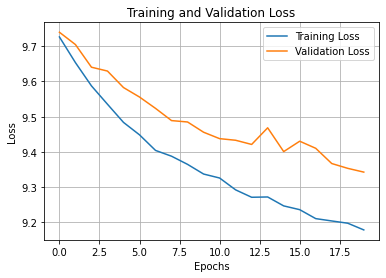

In [20]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid("True")
plt.show()


In [21]:
!pip install mtcnn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 25.4 MB/s eta 0:00:0000:010:01


# VGG

In [22]:
# Load ResNet50 model and customize it
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(1, activation='linear')(x)  # Linear activation for regression

modelVGG = Model(inputs=base_model.input, outputs=predictions)

# Freeze base model layers for transfer learning
for layer in base_model.layers:
    layer.trainable = False

# Compile the model with Mean Absolute Error
modelVGG.compile(optimizer=Adam(learning_rate=0.001), loss='mean_absolute_error', metrics=['mae'])

58900480/58889256 [==============================] - 0s 0us/step


In [24]:
historyVGG = modelVGG.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_steps=val_generator.samples // BATCH_SIZE
)

Epoch 1/20
296/296 [==============================] - 176s 558ms/step - loss: 14.5014 - mae: 14.5014 - val_loss: 12.2324 - val_mae: 12.2324
Epoch 2/20
296/296 [==============================] - 103s 347ms/step - loss: 11.5556 - mae: 11.5556 - val_loss: 11.2034 - val_mae: 11.2034
Epoch 3/20
296/296 [==============================] - 103s 347ms/step - loss: 10.7973 - mae: 10.7973 - val_loss: 10.5414 - val_mae: 10.5414
Epoch 4/20
296/296 [==============================] - 102s 345ms/step - loss: 10.2539 - mae: 10.2539 - val_loss: 10.1928 - val_mae: 10.1928
Epoch 5/20
296/296 [==============================] - 103s 346ms/step - loss: 9.9037 - mae: 9.9037 - val_loss: 9.9143 - val_mae: 9.9143
Epoch 6/20
296/296 [==============================] - 103s 349ms/step - loss: 9.6665 - mae: 9.6665 - val_loss: 9.7154 - val_mae: 9.7154
Epoch 7/20
296/296 [==============================] - 103s 347ms/step - loss: 9.5009 - mae: 9.5009 - val_loss: 9.6147 - val_mae: 9.6147
Epoch 8/20
296/296 [============

In [25]:
modelVGG.save('VGG_age_estimation_model.h5')

print("Model saved successfully!")

Model saved successfully!


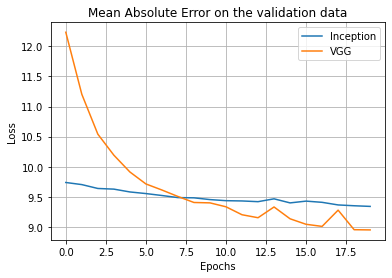

In [28]:
plt.plot(history.history['val_loss'], label='Inception')
plt.plot(historyVGG.history['val_loss'], label='VGG')
plt.title('Mean Absolute Error on the validation data')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid("True")
plt.savefig("Age_evaluation.png")
plt.show()

In [29]:
pip install opencv-python


Note: you may need to restart the kernel to use updated packages.


In [30]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt
from mtcnn import MTCNN
import tensorflow_hub as hub

# Load the model (with KerasLayer and its pre-trained components)
model_path = "/kaggle/working/GoogleNet_age_estimation_model.h5"
model = load_model(model_path, custom_objects={'KerasLayer': hub.KerasLayer})

# Function to detect face and preprocess 
def detect_and_preprocess_face(image_path, target_size=(224, 224)):
    
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Failed to load image at {image_path}")

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    detector = MTCNN()
    faces = detector.detect_faces(image_rgb)
    
    if len(faces) == 0:
        raise ValueError("No face detected in the image.")
    x, y, w, h = faces[0]['box']
    face = image[y:y+h, x:x+w]
    
    face_resized = cv2.resize(face, target_size)
    face_array = img_to_array(face_resized)
    face_array = np.expand_dims(face_array, axis=0)
    face_array = face_array / 255.0  

    image_with_bbox = image.copy()
    cv2.rectangle(image_with_bbox, (x, y), (x + w, y + h), (0, 255, 0), 3)  
    return image_with_bbox, face_array




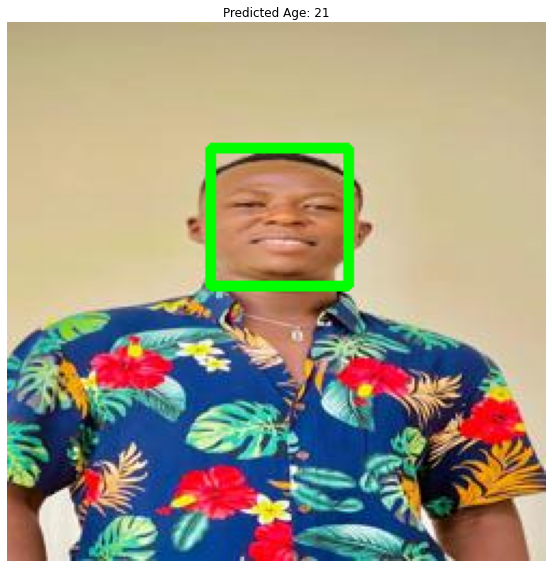

In [31]:
new_image_path = "/kaggle/input/aarondataset/Aaron_Mone_0008 .jpg"  # Replace with your image path

# Detect and preprocess the face from the image
image_with_bbox, processed_face = detect_and_preprocess_face(new_image_path)

# Make prediction (output is the predicted age or any other model-specific output)
predicted_age = model.predict(processed_face)

# Convert the predicted age to an integer (ignore decimals)
predicted_age_int = int(predicted_age[0][0])


# Display the original image with bounding box
plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(image_with_bbox, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for display
plt.axis('off')
plt.title(f"Predicted Age: {predicted_age_int}")
plt.tight_layout()
plt.show()


In [32]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt
from mtcnn import MTCNN
import tensorflow_hub as hub

# Load the model (with KerasLayer and its pre-trained components)
model_path = "/kaggle/working/VGG_age_estimation_model.h5"
model = load_model(model_path)

def detect_and_preprocess_face(image_path, target_size=(224, 224)):
    # Load the image
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Failed to load image at {image_path}")

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    detector = MTCNN()
    faces = detector.detect_faces(image_rgb)
    
    if len(faces) == 0:
        raise ValueError("No face detected in the image.")
    
    x, y, w, h = faces[0]['box']
    face = image[y:y+h, x:x+w]
    
    # Resize and preprocess the face for the model
    face_resized = cv2.resize(face, target_size)
    face_array = img_to_array(face_resized)
    face_array = np.expand_dims(face_array, axis=0)
    face_array = face_array / 255.0  # Normalize

    # Draw a bounding box on the original image around the detected face
    image_with_bbox = image.copy()
    cv2.rectangle(image_with_bbox, (x, y), (x + w, y + h), (0, 255, 0), 3)  # Green rectangle
    return image_with_bbox, face_array




Predicted Age: 25


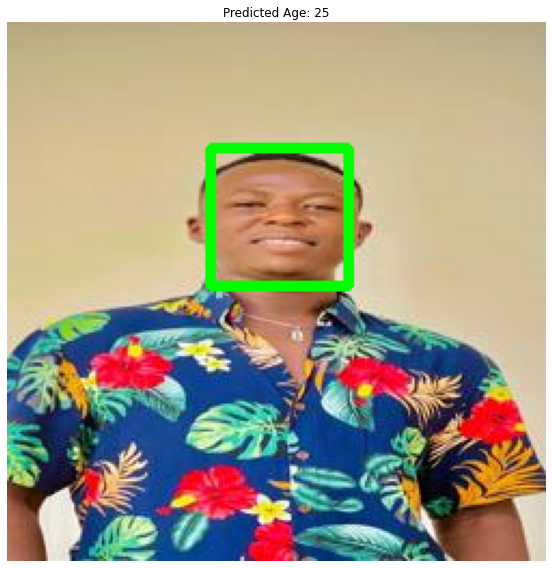

In [34]:
# Path to the new image
new_image_path = "/kaggle/input/aarondataset/Aaron_Mone_0008 .jpg"  # Replace with your image path

# Detect and preprocess the face from the image
image_with_bbox, processed_face = detect_and_preprocess_face(new_image_path)

# Make prediction (output is the predicted age or any other model-specific output)
predicted_age = model.predict(processed_face)

# Convert the predicted age to an integer (ignore decimals)
predicted_age_int = int(predicted_age[0][0])

# Print the whole number of the predicted age
print(f"Predicted Age: {predicted_age_int}")

# Display the original image with bounding box
plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(image_with_bbox, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for display
plt.axis('off')
plt.title(f"Predicted Age: {predicted_age_int}")
plt.tight_layout()
plt.show()